In [2]:
import sys
sys.path.append('../..')

In [3]:
img_path = '/Users/knpob/Territory/Kolmo/data/footprint-to-pressure/footprint/S1-L.jpg'

## Load data

### Pedar sensor pad

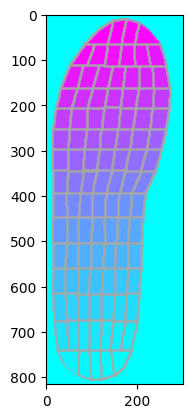

In [4]:
import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

l_mask_path = '../../data/processed/left_foot_mask.png'
l_img = Image.open(l_mask_path)

if 'L.jpg' in img_path:
    arr_pedar = np.array(l_img).astype(np.float64)

elif 'R.jpg' in img_path:
    r_img = ImageOps.mirror(l_img)
    arr_pedar = np.array(r_img).astype(np.float64)

else:
    raise ValueError('Image path should contain "L.jpg" or "R.jpg"')

points_pedar_grid = np.array(np.where(arr_pedar[:-1, : -1] - arr_pedar[1:, 1:] != 0)).T

plt.imshow(arr_pedar, cmap='cool')
plt.scatter(
    points_pedar_grid[:, 1],
    points_pedar_grid[:, 0],
    s=0.1,
    c='darkgray',
)
plt.gca().set_aspect('equal')
plt.show()

### Pedar common contact area

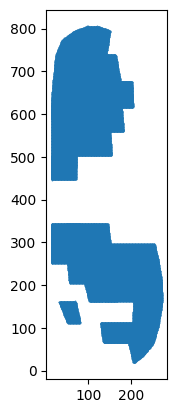

In [5]:
if 'L.jpg' in img_path:
    points_pedar_full = np.load('../../data/processed/points_l_contact.npy')

elif 'R.jpg' in img_path:
    points_pedar_full = np.load('../../data/processed/points_r_contact.npy')

else:
    raise ValueError('Image path should contain "L.jpg" or "R.jpg"')

plt.scatter(points_pedar_full[:, 1], points_pedar_full[:, 0], s=0.1)
plt.gca().set_aspect('equal')
plt.show()

In [6]:
index = np.random.randint(len(points_pedar_full), size=(1000,))
points_pedar = points_pedar_full[index]
pedar_bound = points_pedar.max()
points_pedar = points_pedar / pedar_bound
len(points_pedar), pedar_bound, points_pedar

(1000,
 802,
 array([[0.39900249, 0.06733167],
        [0.67082294, 0.08603491],
        [0.90523691, 0.16957606],
        ...,
        [0.56608479, 0.04738155],
        [0.69451372, 0.13965087],
        [0.8042394 , 0.06109726]]))

### Footprint sample

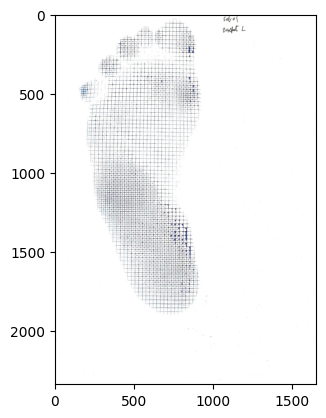

In [7]:
img = Image.open(img_path)
plt.imshow(img)
plt.show()

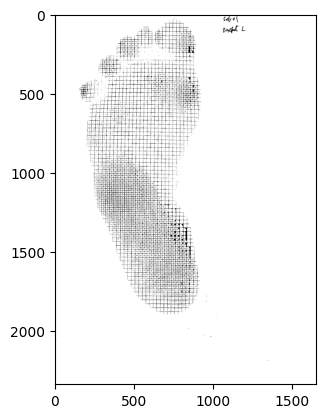

In [8]:
arr_img = np.array(img).astype(np.float64)
filter_thread = 200
filter_map = (np.mean(arr_img, axis=-1) < filter_thread) * 1.0
plt.imshow(1 - filter_map, cmap='gray')
plt.show()

In [9]:
points_footprint_full = np.stack(np.where(filter_map > 0)).T
index = np.random.randint(len(points_footprint_full), size=(1000,))
points_footprint = points_footprint_full[index]
footprint_bound = points_footprint.max()
points_footprint = points_footprint / footprint_bound
len(points_footprint), footprint_bound, points_footprint

(1000,
 1898,
 array([[0.6512118 , 0.20231823],
        [0.48155954, 0.30769231],
        [0.08640674, 0.26343519],
        ...,
        [0.35036881, 0.20969442],
        [0.16701791, 0.26554268],
        [0.63804004, 0.20073762]]))

### Comparison

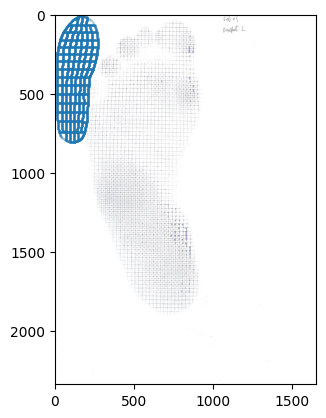

In [10]:
plt.scatter(
    points_pedar_grid[:, 1],
    points_pedar_grid[:, 0],
    s=0.1,
    alpha=0.5,
)
plt.imshow(arr_img / 255, alpha=0.5)
plt.show()

## Rigid CPD registration

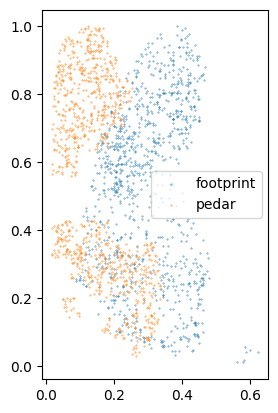

In [11]:
plt.scatter(points_footprint[:, 1], points_footprint[:, 0], s=0.1, label='footprint')
plt.scatter(points_pedar[:, 1], points_pedar[:, 0], s=0.1, label='pedar')
plt.gca().set_aspect('equal')
plt.legend()
plt.show()

### Register pedar to footprint

In [12]:
from probreg import cpd

tf, _, _ = cpd.registration_cpd(points_pedar, points_footprint, 'rigid')
tf.scale, tf.rot, tf.t

(0.9041849226116512,
 array([[ 0.99073005, -0.1358454 ],
        [ 0.1358454 ,  0.99073005]]),
 array([0.02740995, 0.10739754]))

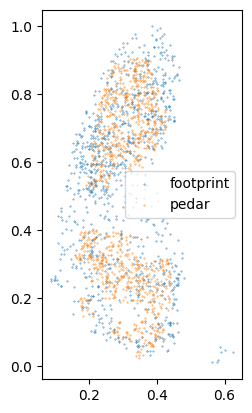

In [13]:
points_trans = tf.transform(points_pedar)

plt.scatter(points_footprint[:, 1], points_footprint[:, 0], s=0.1, label='footprint')
plt.scatter(points_trans[:, 1], points_trans[:, 0], s=0.1, label='pedar')
plt.gca().set_aspect('equal')
plt.legend()
plt.show()

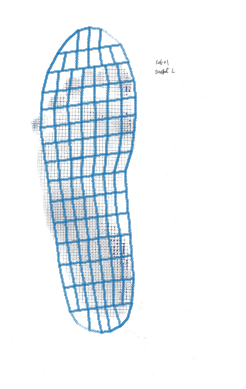

In [14]:
points_trans = tf.transform(points_pedar_grid / pedar_bound) * footprint_bound

shrink_factor = 1.3
center = points_trans.mean(axis=0)
points_trans = shrink_factor * (points_trans - center) + center

plt.imshow(arr_img / 255, cmap='gray')
plt.scatter(points_trans[:, 1], points_trans[:, 0], s=0.1, alpha=0.5)
plt.gca().set_aspect('equal')
plt.axis('off')
plt.show()

### Register footprint to pedar

In [15]:
# tf, _, _ = cpd.registration_cpd(points_footprint, points_pedar, 'rigid')
# tf.scale, tf.rot, tf.t

In [16]:
# points_trans = tf.transform(points_footprint)

# plt.scatter(points_pedar[:, 1], points_pedar[:, 0], s=0.1, label='pedar')
# plt.scatter(points_trans[:, 1], points_trans[:, 0], s=0.1, label='pedar')
# plt.gca().set_aspect('equal')
# plt.legend()
# plt.show()

In [17]:
# points_trans = tf.transform(points_footprint_full / footprint_bound) * pedar_bound

# shrink_factor = 0.85
# center = points_pedar_full.mean(axis=0)
# points_trans = shrink_factor * (points_trans - center) + center

# plt.scatter(
#     points_trans[:, 1], points_trans[:, 0], s=0.1, alpha=0.3, cmap='gray',
#     c=arr_img[points_footprint_full[:, 0], points_footprint_full[:, 1]].mean(axis=-1))
# plt.scatter(points_pedar_grid[:, 1], points_pedar_grid[:, 0], s=0.1, alpha=0.5)
# plt.gca().set_aspect('equal')
# plt.show()

## Warp & resample footprint image

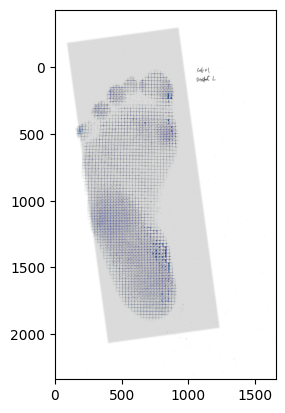

In [18]:
# pedar grid pixels coordinates warped to the footprint image
pedar_px = np.array(np.where(arr_pedar > -1)).T
points_trans = tf.transform(pedar_px / pedar_bound) * footprint_bound
points_trans = shrink_factor * (points_trans - center) + center

plt.imshow(arr_img / 255, cmap='gray')
plt.scatter(points_trans[:, 1], points_trans[:, 0], s=0.1, alpha=0.01)
plt.gca().set_aspect('equal')
plt.show()

In [19]:
from scipy.interpolate import RegularGridInterpolator

x_img = np.arange(arr_img.shape[0])
y_img = np.arange(arr_img.shape[1])
footprint_interp = RegularGridInterpolator(
    points = (x_img, y_img),
    values = arr_img.mean(axis=-1),
    bounds_error=False,
    fill_value=255,
    )

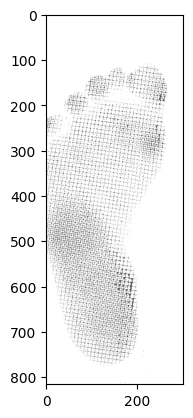

In [20]:
arr_resample = footprint_interp(points_trans).reshape(arr_pedar.shape)
plt.imshow(arr_resample / 255, cmap='gray')
plt.show()